In [ ]:
# libs
import os, glob, re
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from pesq import pesq
from pystoi import stoi
from scipy.signal import butter, sosfilt
from numpy.linalg import svd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [ ]:
!pip install pesq pystoi

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=275935 sha256=49253fedd00f3f91b11e65b47dd8fe229963294bd96ee5c8164ce03e0a0cc0c3
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [ ]:
# folders
noisy_dirs = [
    '/content/drive/MyDrive/NoisySpeech/',
    '/content/drive/MyDrive/NoisySpeech02/',
    '/content/drive/MyDrive/NoisySpeech03/',
    '/content/drive/MyDrive/NoisySpeech04/',
    '/content/drive/MyDrive/NoisySpeech05/',
    '/content/drive/MyDrive/NoisySpeech06/'
]

clean_files = [
    '/content/drive/MyDrive/Datasets/Speech01.wav',
    '/content/drive/MyDrive/Datasets/Speech02.wav',
    '/content/drive/MyDrive/Datasets/Speech03.wav',
    '/content/drive/MyDrive/Datasets/Speech04.wav',
    '/content/drive/MyDrive/Datasets/Speech05.wav',
    '/content/drive/MyDrive/Datasets/Speech06.wav'
]

def bandpass(data, fs, low=300, high=3000, order=5):
    ny = 0.5 * fs
    sos = butter(order, [low/ny, high/ny], btype='band', output='sos')
    return sosfilt(sos, data)

def svd_denoise(y, sr, energy_thresh=0.95):
    y = bandpass(y, sr)
    D = librosa.stft(y)
    mag, phase = librosa.magphase(D)

    U, S, V = svd(mag, full_matrices=False)
    energy = np.cumsum(S) / np.sum(S)
    k = np.argmax(energy >= energy_thresh) + 1

    S_filtered = np.zeros_like(S)
    S_filtered[:k] = S[:k]

    denoised_mag = U @ np.diag(S_filtered) @ V
    denoised = denoised_mag * phase
    return librosa.istft(denoised)

def resample_audio(path, sr=16000):
    y, fs = librosa.load(path, sr=None)
    if fs != sr:
        y = librosa.resample(y, fs, sr)
    return y, sr

def trim_match(a, b):
    n = min(len(a), len(b))
    return a[:n], b[:n]

def snr(signal, noise):
    return 10 * np.log10(np.mean(signal**2) / np.mean(noise**2))

def segsnr(noisy, clean):
    segments = librosa.effects.split(noisy, top_db=20)
    out = []
    for s, e in segments:
        sig = clean[s:e]
        n = noisy[s:e] - sig
        out.append(snr(sig, n))
    return np.mean(out)

def cep_dist(a, b, sr):
    mfcc1 = librosa.feature.mfcc(y=a, sr=sr)
    mfcc2 = librosa.feature.mfcc(y=b, sr=sr)
    return np.mean(np.abs(mfcc1 - mfcc2))

# storing results
out = []

# loop through folders
for idx, folder in enumerate(noisy_dirs):
    y_clean, sr = resample_audio(clean_files[idx])

    for file in glob.glob(os.path.join(folder, '*.wav')):
        fname = os.path.basename(file).replace('.wav', '')
        m = re.match(r"Speech\d+_with_(\w+)_\d+_SNR_(\d+)dB", fname)
        if not m: continue
        noise_type, snr_lvl = m.group(1), int(m.group(2))

        y_noisy, _ = resample_audio(file)
        y_c, y_n = trim_match(y_clean, y_noisy)

        # pre scores
        pesq_pre = pesq(sr, y_c, y_n, 'wb')
        stoi_pre = stoi(y_c, y_n, sr)
        seg_pre = segsnr(y_n, y_n - y_c)
        cep_pre = cep_dist(y_n, y_n - y_c, sr)

        # denoise
        y_d = svd_denoise(y_noisy, sr)
        y_c, y_d = trim_match(y_clean, y_d)

        # post scores
        pesq_post = pesq(sr, y_c, y_d, 'wb')
        stoi_post = stoi(y_c, y_d, sr)
        seg_post = segsnr(y_d, y_d - y_c)
        cep_post = cep_dist(y_d, y_d - y_c, sr)

        # snr stuff
        _, y_c_match = trim_match(y_n, y_c)
        _, y_c_post = trim_match(y_d, y_c)
        snr_before = snr(y_n, y_n - y_c_match)
        snr_after = snr(y_d, y_d - y_c_post)

        out.append({
            'File': fname,
            'Noise Type': noise_type,
            'Noise Level (dB)': snr_lvl,
            'Pre-SVD PESQ': pesq_pre,
            'Post-SVD PESQ': pesq_post,
            'Pre-SVD STOI': stoi_pre,
            'Post-SVD STOI': stoi_post,
            'Noise Reduction (dB)': snr_after - snr_before,
            'PESQ Improvement': pesq_post - pesq_pre,
            'STOI Improvement': stoi_post - stoi_pre,
            'SegSNR Before': seg_pre,
            'SegSNR After': seg_post,
            'Cepstral Distance Before': cep_pre,
            'Cepstral Distance After': cep_post,
            'SegSNR Improvement': seg_post - seg_pre,
            'Cepstral Distance Improvement': cep_post - cep_pre
        })

df = pd.DataFrame(out)

# avg segs of noise type
t1 = df.groupby('Noise Type').agg({
    'PESQ Improvement': 'mean',
    'STOI Improvement': 'mean',
    'SegSNR Before': 'mean',
    'SegSNR After': 'mean',
    'Cepstral Distance Before': 'mean',
    'Cepstral Distance After': 'mean'
}).reset_index()

# avg segs of snr
t2 = df.groupby('Noise Level (dB)').agg({
    'PESQ Improvement': 'mean',
    'STOI Improvement': 'mean',
    'SegSNR Before': 'mean',
    'SegSNR After': 'mean',
    'Cepstral Distance Before': 'mean',
    'Cepstral Distance After': 'mean'
}).reset_index()

print("Table 1 - avg by noise type\n", t1)
print("\nTable 2 - avg by snr\n", t2)

# save
t1.to_csv('/content/drive/MyDrive/noise_speech_results_table1.csv', index=False)
t2.to_csv('/content/drive/MyDrive/noise_speech_results_table2.csv', index=False)

Table 1 (Averaged by Noise Type):
       Noise Type  PESQ Improvement  STOI Improvement  SegSNR Before  \
0  AirConditioner          0.178104         -0.024999     -11.501240   
1          Babble          0.011492         -0.029432     -12.192281   
2        Munching          0.182407         -0.041528     -12.765615   
3          Typing          0.079181         -0.029242     -10.106285   
4   VacuumCleaner          0.239788         -0.032443     -13.244028   

   SegSNR After  Cepstral Distance Before  Cepstral Distance After  
0      2.826815                 16.638821                24.519300  
1      3.456150                 16.017792                24.666918  
2      4.357715                 23.010145                24.065247  
3      5.105753                 17.427233                24.003702  
4      3.053953                 12.179730                23.914315  

Table 2 (Averaged by Noise Level):
   Noise Level (dB)  PESQ Improvement  STOI Improvement  SegSNR Before  \
0        

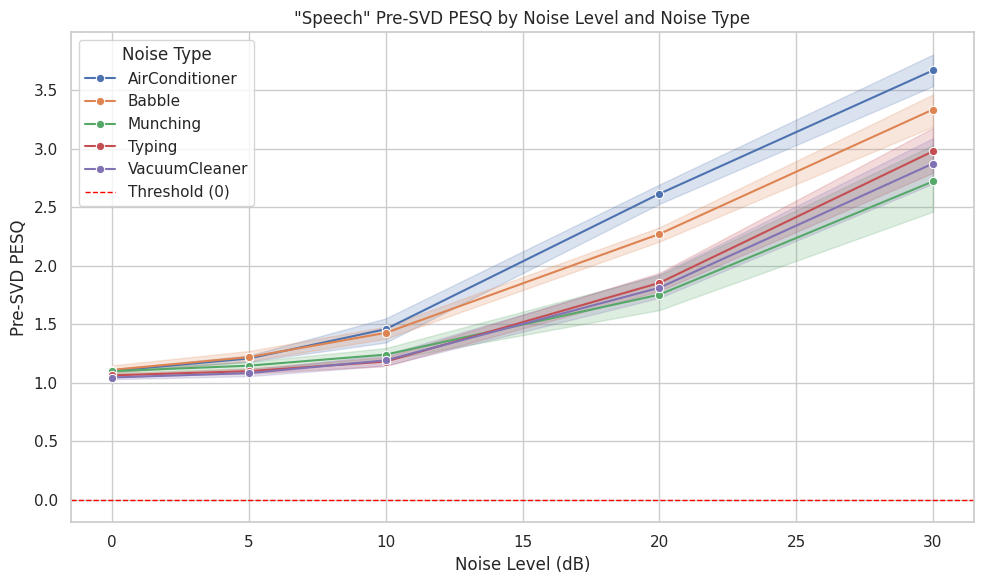

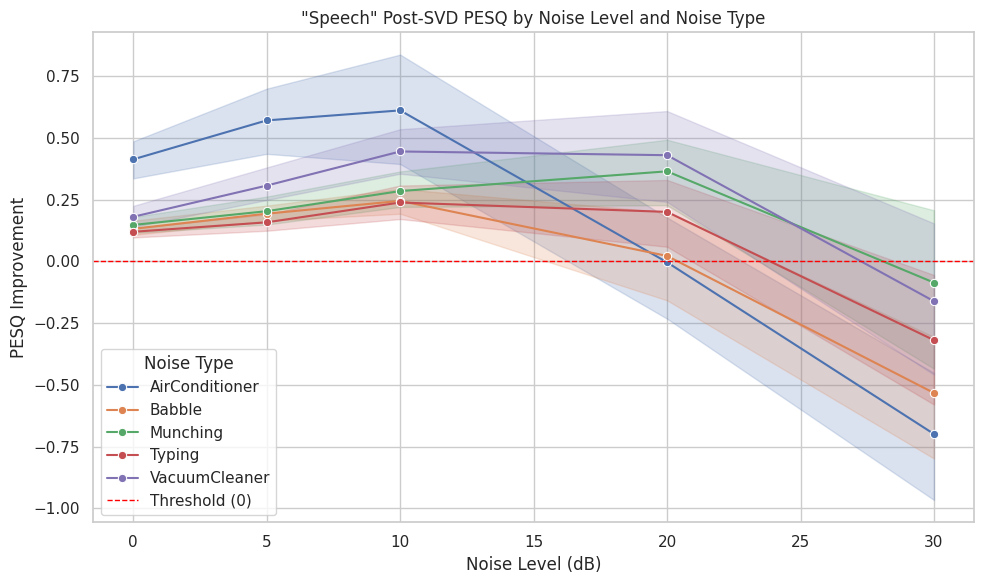

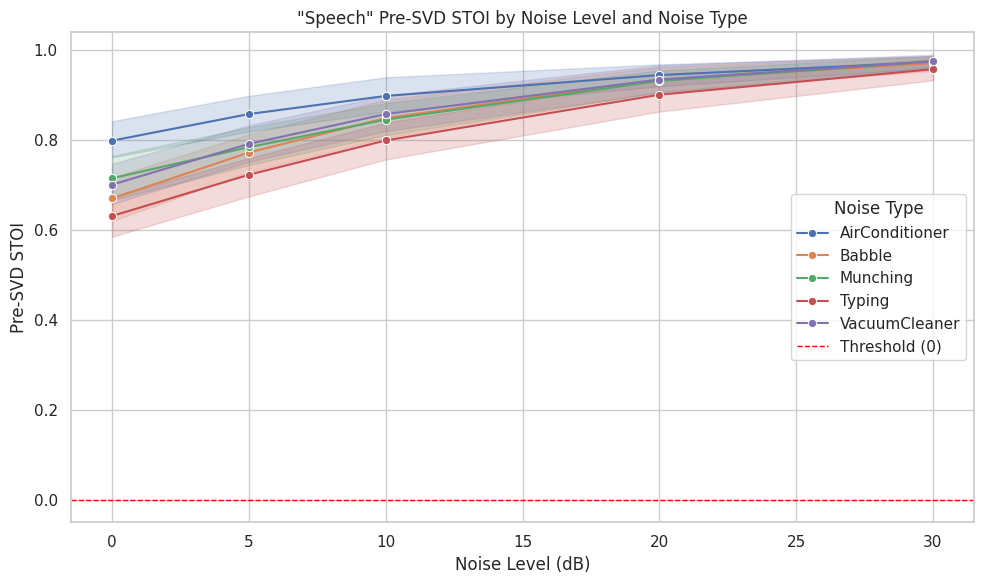

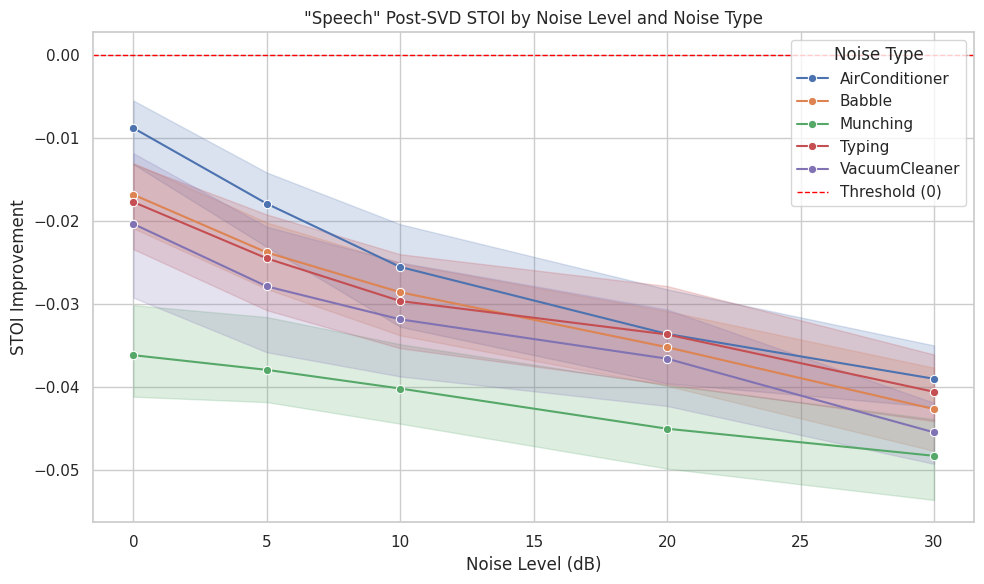

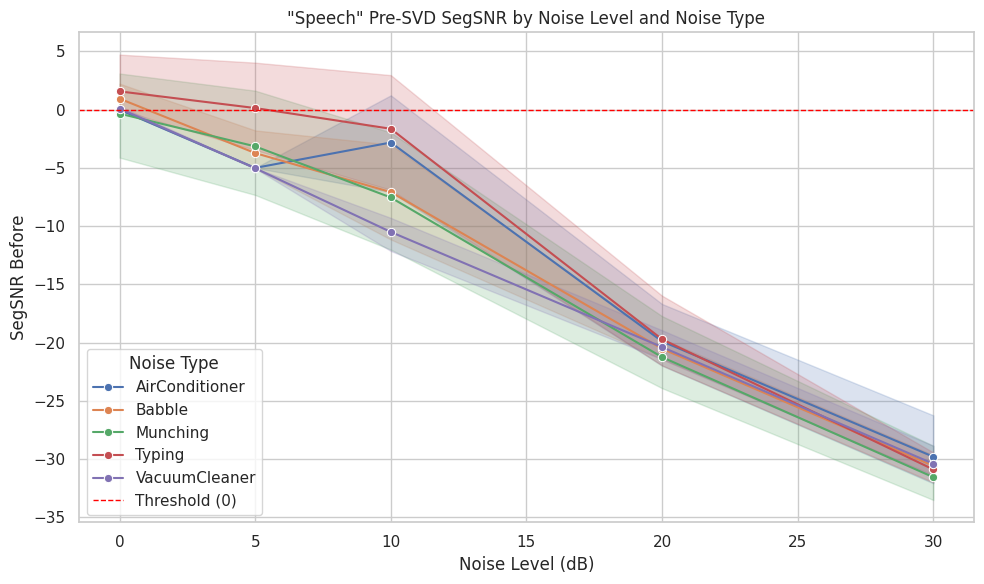

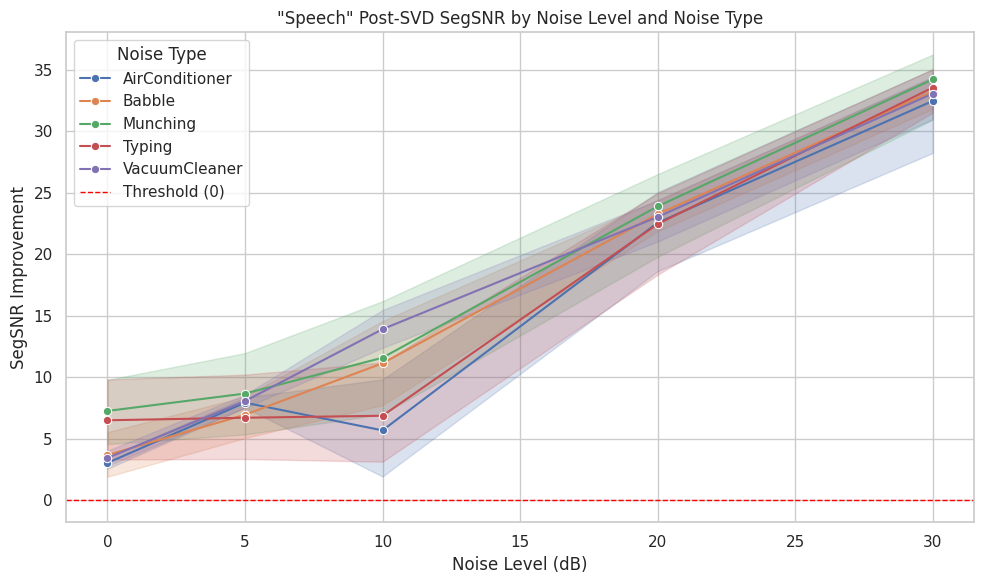

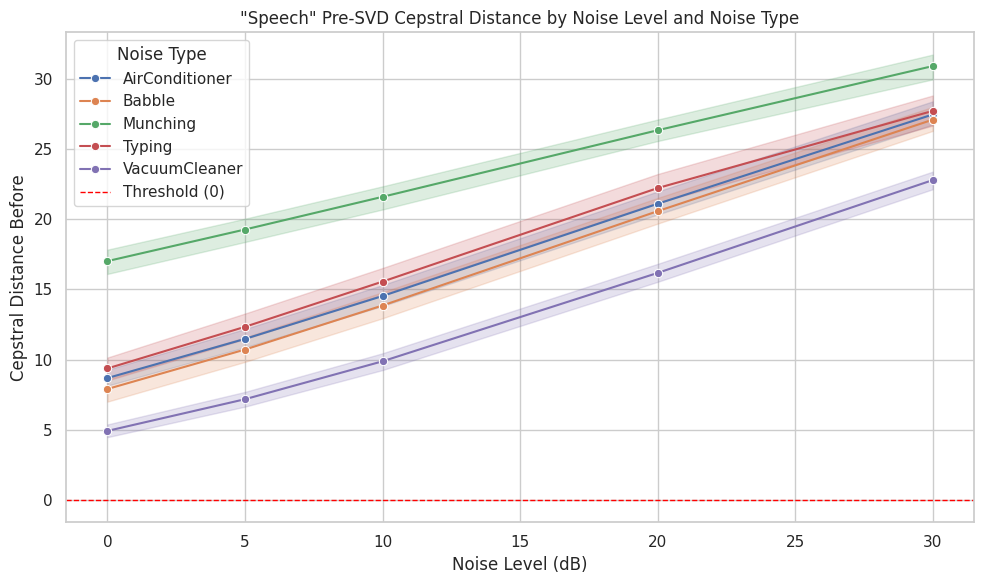

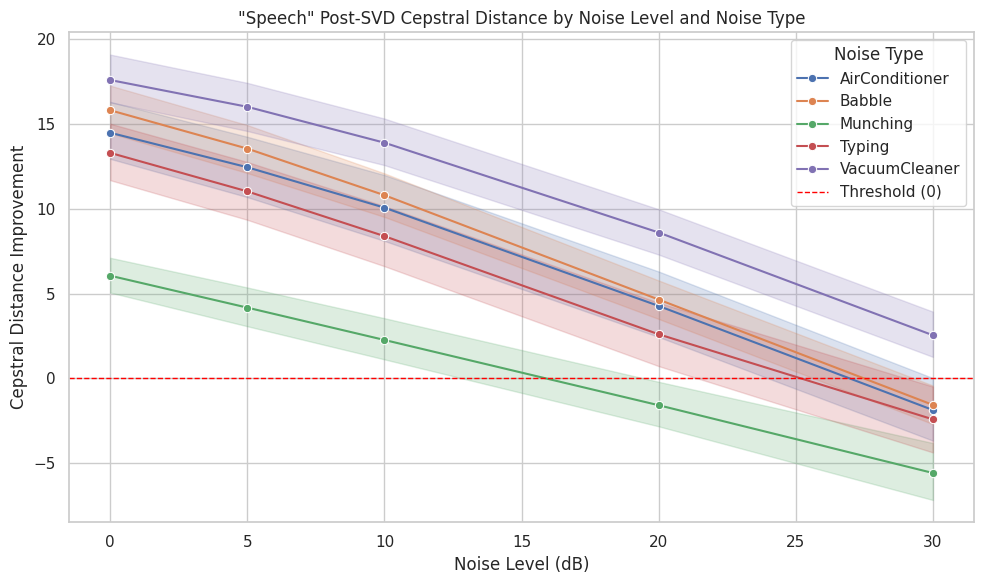

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# starting information
pre = df_results[['Noise Level (dB)', 'Noise Type', 'Pre-SVD PESQ', 'Pre-SVD STOI', 'SegSNR Before', 'Cepstral Distance Before']]

# quick helper
def plot_line(df, x, y, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=x, y=y, hue='Noise Type', marker='o')
    plt.axhline(0, color='red', ls='--', lw=1)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.legend(title='Noise Type')
    plt.tight_layout()
    plt.show()

# PESQ
plot_line(pre, 'Noise Level (dB)', 'Pre-SVD PESQ', 'Pre-SVD PESQ vs Noise Level', 'Pre-SVD PESQ')
plot_line(df_results, 'Noise Level (dB)', 'PESQ Improvement', 'PESQ Gain vs Noise Level', 'PESQ Improvement')

# STOI
plot_line(pre, 'Noise Level (dB)', 'Pre-SVD STOI', 'Pre-SVD STOI vs Noise Level', 'Pre-SVD STOI')
plot_line(df_results, 'Noise Level (dB)', 'STOI Improvement', 'STOI Gain vs Noise Level', 'STOI Improvement')

# SegSNR
plot_line(pre, 'Noise Level (dB)', 'SegSNR Before', 'Pre-SVD SegSNR vs Noise Level', 'SegSNR Before')
plot_line(df_results, 'Noise Level (dB)', 'SegSNR Improvement', 'SegSNR Gain vs Noise Level', 'SegSNR Improvement')

# Cepstral Distance
plot_line(pre, 'Noise Level (dB)', 'Cepstral Distance Before', 'Pre-SVD CepDist vs Noise Level', 'Cepstral Dist Before')
plot_line(df_results, 'Noise Level (dB)', 'Cepstral Distance Improvement', 'Cepstral Dist Gain vs Noise Level', 'Cepstral Dist Improvement')


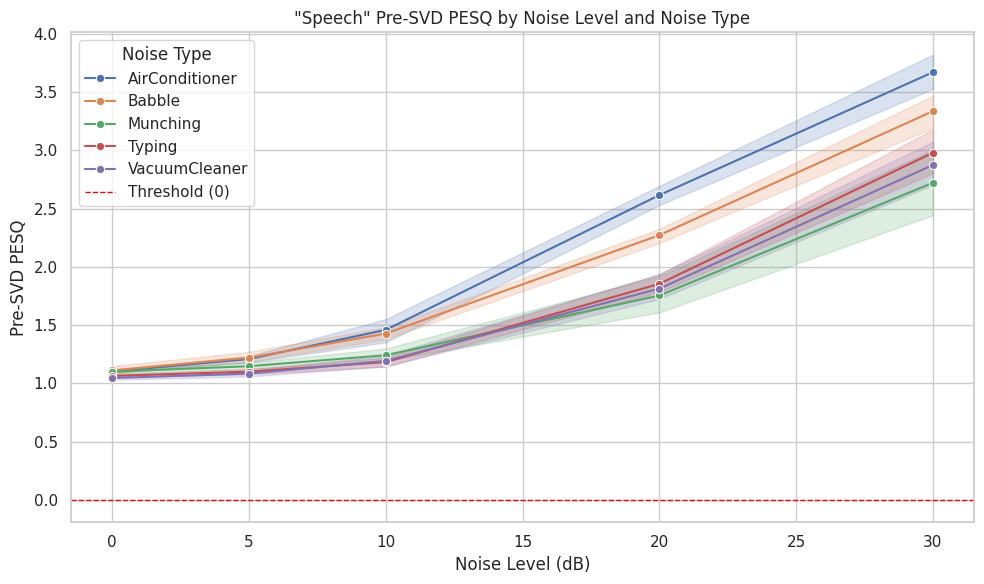

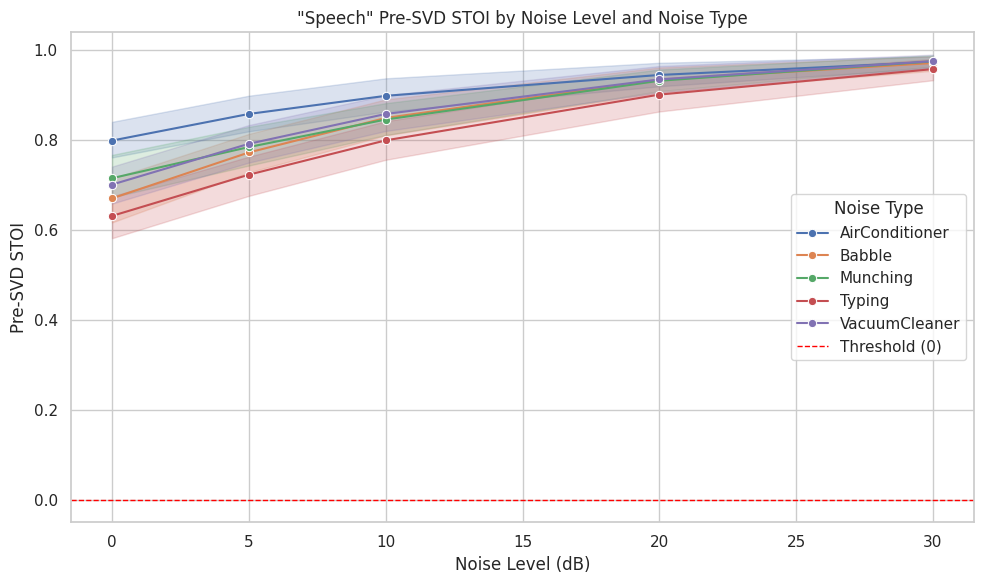

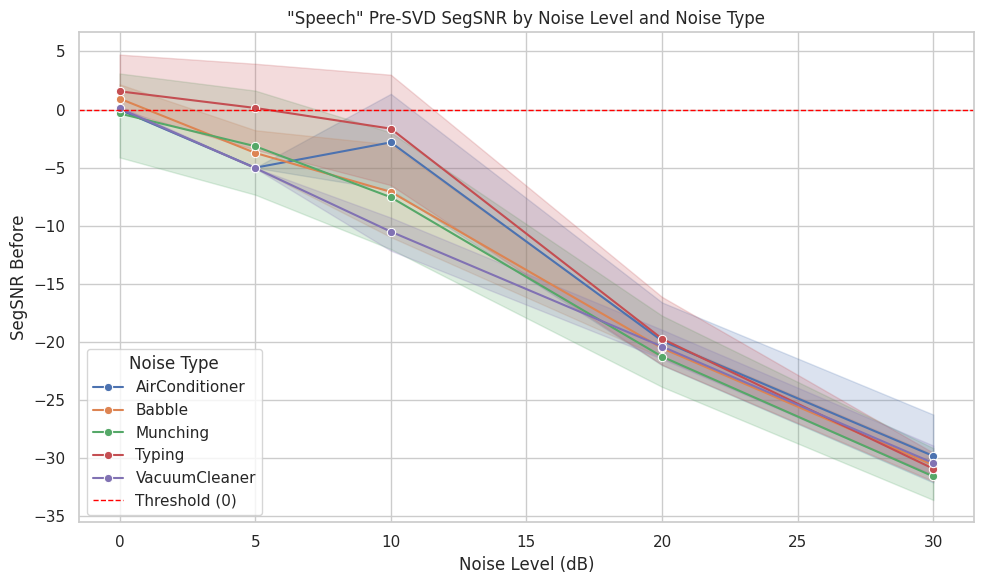

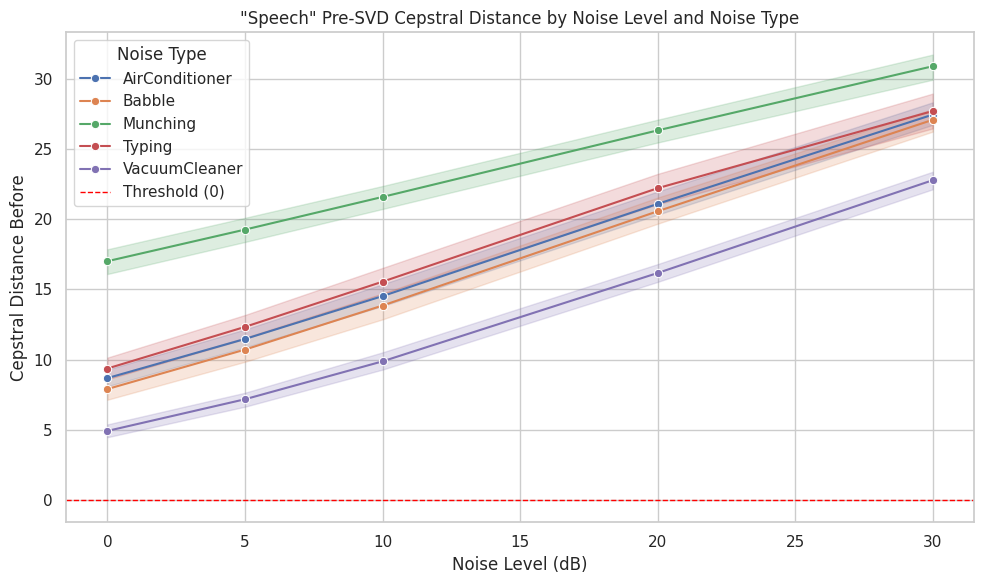

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# starting information
pre = df_results[['Noise Level (dB)', 'Noise Type', 'Pre-SVD PESQ', 'Pre-SVD STOI', 'SegSNR Before', 'Cepstral Distance Before']]

def plot_pre(df, yval, label):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Noise Level (dB)', y=yval, hue='Noise Type', marker='o')
    plt.axhline(0, color='red', ls='--', lw=1)
    plt.title(f'Pre-SVD {label} vs Noise Level')
    plt.xlabel('Noise Level (dB)')
    plt.ylabel(label)
    plt.legend(title='Noise Type')
    plt.tight_layout()
    plt.show()

plot_pre(pre, 'Pre-SVD PESQ', 'PESQ')
plot_pre(pre, 'Pre-SVD STOI', 'STOI')
plot_pre(pre, 'SegSNR Before', 'SegSNR')
plot_pre(p_


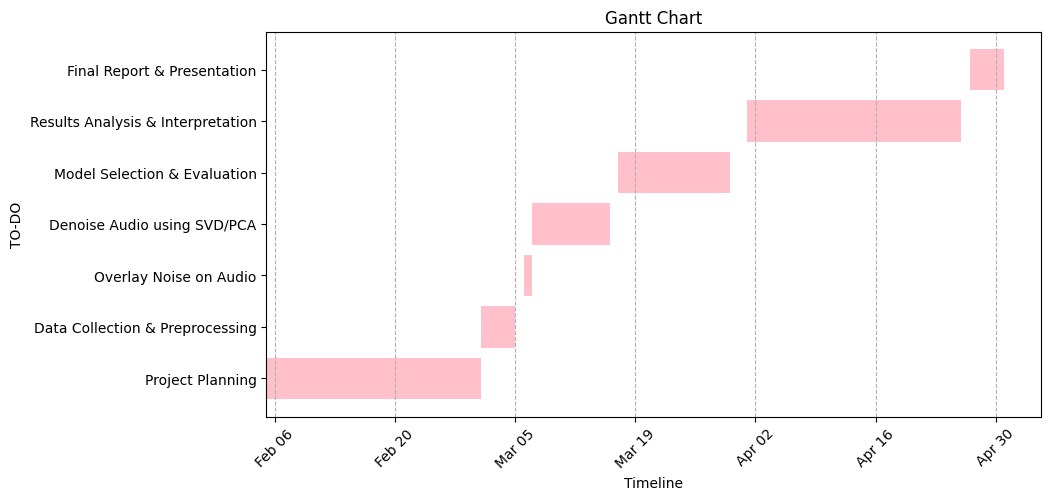

In [ ]:
tasks = [
    ("Project Planning", "2024-02-05", "2024-03-01"),
    ("Data Collection & Preprocessing", "2024-03-01", "2024-03-05"),
    ("Overlay Noise on Audio", "2024-03-06", "2024-03-07"),
    ("Denoise Audio using SVD/PCA", "2024-03-07", "2024-03-16"),
    ("Model Selection & Eval", "2024-03-17", "2024-03-30"),
    ("Results Analysis", "2024-04-01", "2024-04-26"),
    ("Final Report + Slides", "2024-04-27", "2024-05-01"),
]

df = pd.DataFrame(tasks, columns=["Task", "Start", "End"])
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])
df["Duration"] = (df["End"] - df["Start"]).dt.days

fig, ax = plt.subplots(figsize=(10, 5))
for i, row in df.iterrows():
    ax.barh(row.Task, row.Duration, left=row.Start, color='pink')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)
plt.title("To-Do Timeline")
plt.xlabel("Date")
plt.ylabel("Task")
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()
